In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score,r2_score
from datetime import datetime, timedelta
# import yfinance as yf
import matplotlib.pyplot as plt


class regression_model:
    def __init__(self, model_name, data, test_size, lookback, pred_ndays):    
        self.model_name = model_name
        self.data = data
        self.data['date'] = pd.to_datetime(self.data['date'])
        self.test_size = test_size
        self.lookback = lookback
        self.pred_ndays = pred_ndays


    def correct_weekday(self,select_date):
        #monday is 0 and sunday is 6
        state = None
        if select_date.weekday() > 4:
                select_date = select_date - timedelta(select_date.weekday()-4)
        else:
            pass
        return select_date

    def metric_score(self, original_ytrain, train_predict, original_ytest, test_predict):
        res = pd.DataFrame(index=['metrics'])
        res['train_variance_score'] = explained_variance_score(original_ytrain, train_predict)
        res['test_variance_score'] = explained_variance_score(original_ytest, test_predict)

        res['train_r2_score'] = r2_score(original_ytrain, train_predict)
        res['test_r2_score'] = r2_score(original_ytest, test_predict)
        res=res.reset_index(drop=True)
        return res

    def run(self):
        dates = self.data['date']
        df = self.data['close']
        scaler= MinMaxScaler(feature_range=(0,1))
        #scaler = StandardScaler()
        df=scaler.fit_transform(np.array(df).reshape(-1,1))

        test_split_idx = int(df.shape[0]*(1-self.test_size))

        train_data = df[:test_split_idx].copy()
        test_data = df[test_split_idx:].copy()
    

        #Idea look e.g. n days of input data to predict the next day
        # convert an array of values into a dataset matrix
        def create_dataset(dataset):
            dataX, dataY = [], []
            for i in range(len(dataset)-self.lookback-1):
                a = dataset[i:(i+self.lookback), 0]   ###i=0, 0,1,2,3-----99   100 
                dataX.append(a)
                dataY.append(dataset[i + self.lookback, 0])
            return np.array(dataX), np.array(dataY)

        def create_date_dataset(dataset):
            dataX= []
            for i in range(len(dataset)-self.lookback-1):
                a = dataset[i:(i+self.lookback)].iloc[-1]   ###i=0, 0,1,2,3-----99   100 
                dataX.append(a)
            return pd.DataFrame(dataX)

        # reshape into X=t,t+1,t+2,t+3 and Y=t+4
        #self.lookback = 100


        X_train, y_train = create_dataset(train_data)
        X_test, y_test = create_dataset(test_data)


        if self.model_name == 'Linear Regression':
            model = LinearRegression()
        elif self.model_name == "XGBoost":
            model = XGBRegressor()
        elif self.model_name == "Support Vector Regressor":
            model = SVR()
        elif self.model_name == 'Random Forest Regressor':
            model = RandomForestRegressor()
        else:
            model = LinearRegression()
            
        
        model.fit(X_train,y_train)


        #====Start-Backtesting====#
        train_predict=model.predict(X_train)
        train_predict = train_predict.reshape(-1,1)
        test_predict=model.predict(X_test)
        test_predict = test_predict.reshape(-1,1)

        train_predict = scaler.inverse_transform(train_predict)
        test_predict = scaler.inverse_transform(test_predict)
        original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
        original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

        metric = self.metric_score(original_ytrain, train_predict, original_ytest, test_predict)
        #====End-Backtesting====#



        #====Start-Prepare-Train-Test-Data-for-Plot====#
        train_dates = dates[:test_split_idx].copy()
        test_dates = dates[test_split_idx:].copy()
        

        train_dates = create_date_dataset(train_dates)
        test_dates = create_date_dataset(test_dates)

        train_res = pd.DataFrame()
        train_res['date'] = train_dates
        train_res['train'] = pd.DataFrame(train_predict)

        test_res = pd.DataFrame()
        test_res['date'] = test_dates
        test_res['test'] = pd.DataFrame(test_predict)
        #====End-Prepare-Train-Test-Data-for-Plot====#



        #====Start-Predicting-N-Days====#
        x_input=test_data[len(test_data)-self.lookback:].reshape(1,-1)
        temp_input=list(x_input)
        temp_input=temp_input[0].tolist()

        model_output=[]
        i=0
        
        skip_date = self.data['date'].iloc[-1]
        check_date = self.correct_weekday(skip_date)

        future_dates = []
        while len(model_output) < self.pred_ndays:
            while_date = self.correct_weekday(skip_date + timedelta(i))

            if while_date != check_date:

                check_date = while_date

                future_dates.append(check_date)

                if len(temp_input) > self.lookback:
                    x_input = np.array(temp_input[1:])
                    x_input = x_input.reshape(1,-1)

                    yhat = model.predict(x_input)

                    temp_input.extend(yhat.tolist())
                    temp_input = temp_input[1:]
                    model_output.extend(yhat.tolist())
                else:
                    yhat = model.predict(x_input)
                    temp_input.extend(yhat.tolist())
                    model_output.extend(yhat.tolist())

            else:
                pass
            
            i += 1

            # Check if model_output has reached desired length
            if len(model_output) >= self.pred_ndays:
                break


        future_dates = pd.DataFrame(future_dates)
    
        future_dates['date'] = future_dates[0]

        new_pred_df = (np.array(model_output).reshape(-1,1)).tolist()
        new_pred_df = pd.DataFrame(scaler.inverse_transform(new_pred_df).reshape(1,-1).tolist()[0])

        pred_res = pd.DataFrame()
        pred_res['date'] = future_dates['date']
        pred_res['yhat'] = new_pred_df

        #print(pred_res)
        #====End-Predicting-N-Days====#
        return metric,train_res,test_res,pred_res



def plot_result(train_df, test_df, pred_df):

    fig, ax = plt.subplots(figsize=(20, 10))
    
    #Only plot the last 100 datapoints
    plot_train_df = train_df[-100:].reset_index(drop=True)
    new_index = range(len(plot_train_df), len(plot_train_df)+len(test_df))
    
    test_df.index = new_index        
    

    mask = (df['date'] >= plot_train_df['date'].iloc[0]) & (df['date'] <= test_df['date'].iloc[-1])
    # filter the dataframe using the boolean mask
    actual_df = df.loc[mask].reset_index(drop=True)



    ax.plot(actual_df['date'],actual_df['close'], linewidth=2, color='black',label='Actual Price')
    ax.plot(plot_train_df['date'],plot_train_df['train'], linewidth=2.5,linestyle="dashed", color='blue',label='Train set')
    ax.plot(test_df['date'],test_df['test'], linewidth=2.5,linestyle="dashed",color='red',label='Test set')

    ax.plot(pred_df['date'],pred_df['yhat'], linewidth=2.5, color='green',label='Next 30 days')

    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=15,length=9,direction='in')
    plt.tick_params(axis='both', which='minor', labelsize=9,length=5,direction='in')


    legend = ax.legend(loc="best", shadow=True, fontsize=25)
    ax.set_title(model_name, fontsize=25)


    plt.xlabel("Date", fontsize=25)
    plt.ylabel("Price", fontsize=25)
    #plt.show()
#     plt.savefig("plots/%s.png" % model_name,bbox_inches='tight')



def plot_metric(train_var_list, train_r2_list, test_var_list, test_r2_list):

    # Define the scores for each model
    linear_regression_scores = {
        'Train Variance Score': train_var_list[0],
        'Test Variance Score': test_var_list[0],
        'Train R2 Score': train_r2_list[0],
        'Test R2 Score': test_r2_list[0]
    }

    support_vector_scores = {
        'Train Variance Score': train_var_list[1],
        'Test Variance Score': test_var_list[1],
        'Train R2 Score': train_r2_list[1],
        'Test R2 Score': test_r2_list[1]
    }
    random_forest_scores = {
        'Train Variance Score': train_var_list[2],
        'Test Variance Score': test_var_list[2],
        'Train R2 Score': train_r2_list[2],
        'Test R2 Score': test_r2_list[2]
    }

    # Create lists of labels and values for all models
    labels = ['Train Variance Score', 'Test Variance Score', 'Train R2 Score', 'Test R2 Score']
    linear_regression_values = [linear_regression_scores[label] for label in labels]
    support_vector_values = [support_vector_scores[label] for label in labels]
    random_forest_values = [random_forest_scores[label] for label in labels]

    # Create a horizontal bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    box = ax.get_position()

    # Set the y-axis labels
    y_pos = np.arange(len(labels))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=12)
    ax.set_yticklabels(labels, fontsize=12)


    plt.tick_params(axis='both', which='major', labelsize=15,length=9,direction='in')
    plt.tick_params(axis='both', which='minor', labelsize=9,length=5,direction='in')



   

    # Set the x-axis limits
    ax.set_xlim([0, 1])

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_position([box.x0, box.y0, box.width, box.height])
   

    # Add a title
    ax.set_title('Model Scores', fontsize=22)

    # Plot the scores for each model
    ax.barh(y_pos-0.2, linear_regression_values, height=0.2, align='center', color='#2C27D8',alpha=0.7)
    ax.barh(y_pos, random_forest_values, height=0.2, align='center', color='#27D82C',alpha=0.7)
    ax.barh(y_pos+0.2, support_vector_values, height=0.2, align='center', color='#D82C27',alpha=0.7)

    # Add the scores as text labels
    for i, v in enumerate(linear_regression_values):
        ax.text(v + 0.01, i-0.2, str(round(v, 2)), color='black', fontsize=13)
        ax.text(random_forest_values[i] + 0.01, i, str(round(random_forest_values[i], 2)), color='black', fontsize=13)
        ax.text(support_vector_values[i] + 0.01, i+0.2, str(round(support_vector_values[i], 2)), color='black', fontsize=13)

    # Add a legend
    ax.legend(['Linear Regression', 'Random Forest Regressor', 'Suppor Vector Regressor'], loc='lower left', \
        bbox_to_anchor=(0.15, -0.40),shadow=True,fontsize=20)


#     plt.savefig("plots/metric_score.png",bbox_inches='tight')






   train_variance_score  test_variance_score  train_r2_score  test_r2_score
0              0.992781             0.856601        0.992781       0.855968
Linear Regression finished
   train_variance_score  test_variance_score  train_r2_score  test_r2_score
0              0.931541             0.640416        0.724737       0.549285
Support Vector Regressor finished
   train_variance_score  test_variance_score  train_r2_score  test_r2_score
0              0.998688               0.8438        0.998688       0.843492
Random Forest Regressor finished
Gia tri du đoan cua random forest:          date   yhat
0  2024-01-01  6.049
1  2024-01-02  6.066
2  2024-01-03  6.216
3  2024-01-04  6.125
4  2024-01-05  6.010
5  2024-01-08  6.025
6  2024-01-09  5.985
7  2024-01-10  6.050
8  2024-01-11  6.073
9  2024-01-12  6.120
10 2024-01-15  6.110
11 2024-01-16  6.136
12 2024-01-17  6.165
13 2024-01-18  6.194
14 2024-01-19  6.193
15 2024-01-22  6.215
16 2024-01-23  6.200
17 2024-01-24  6.201
18 2024-01-25  6

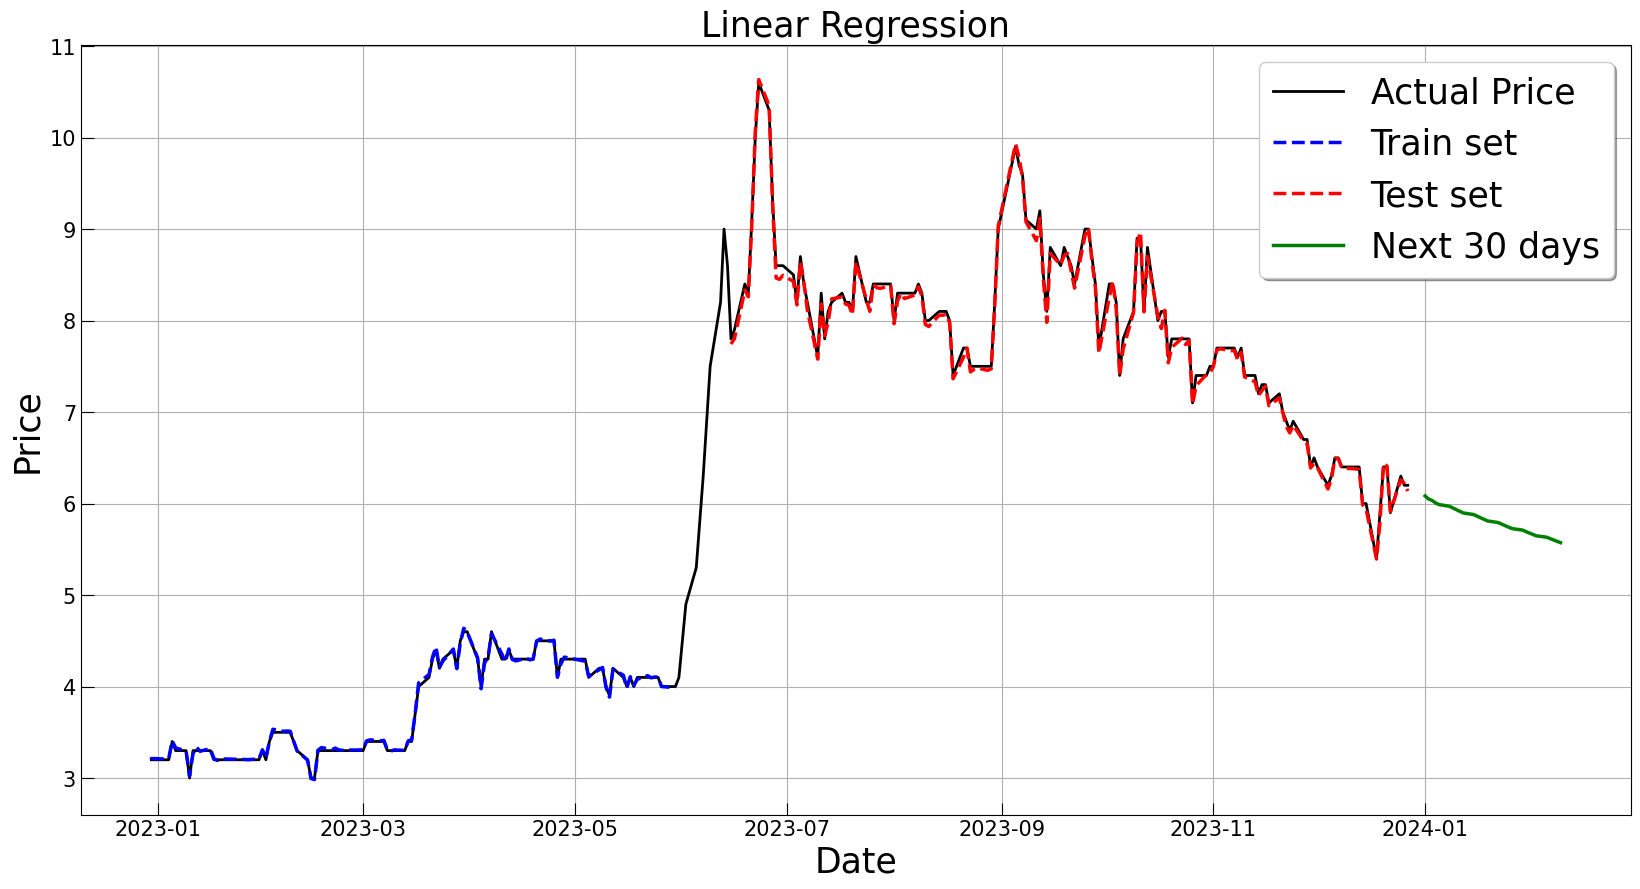

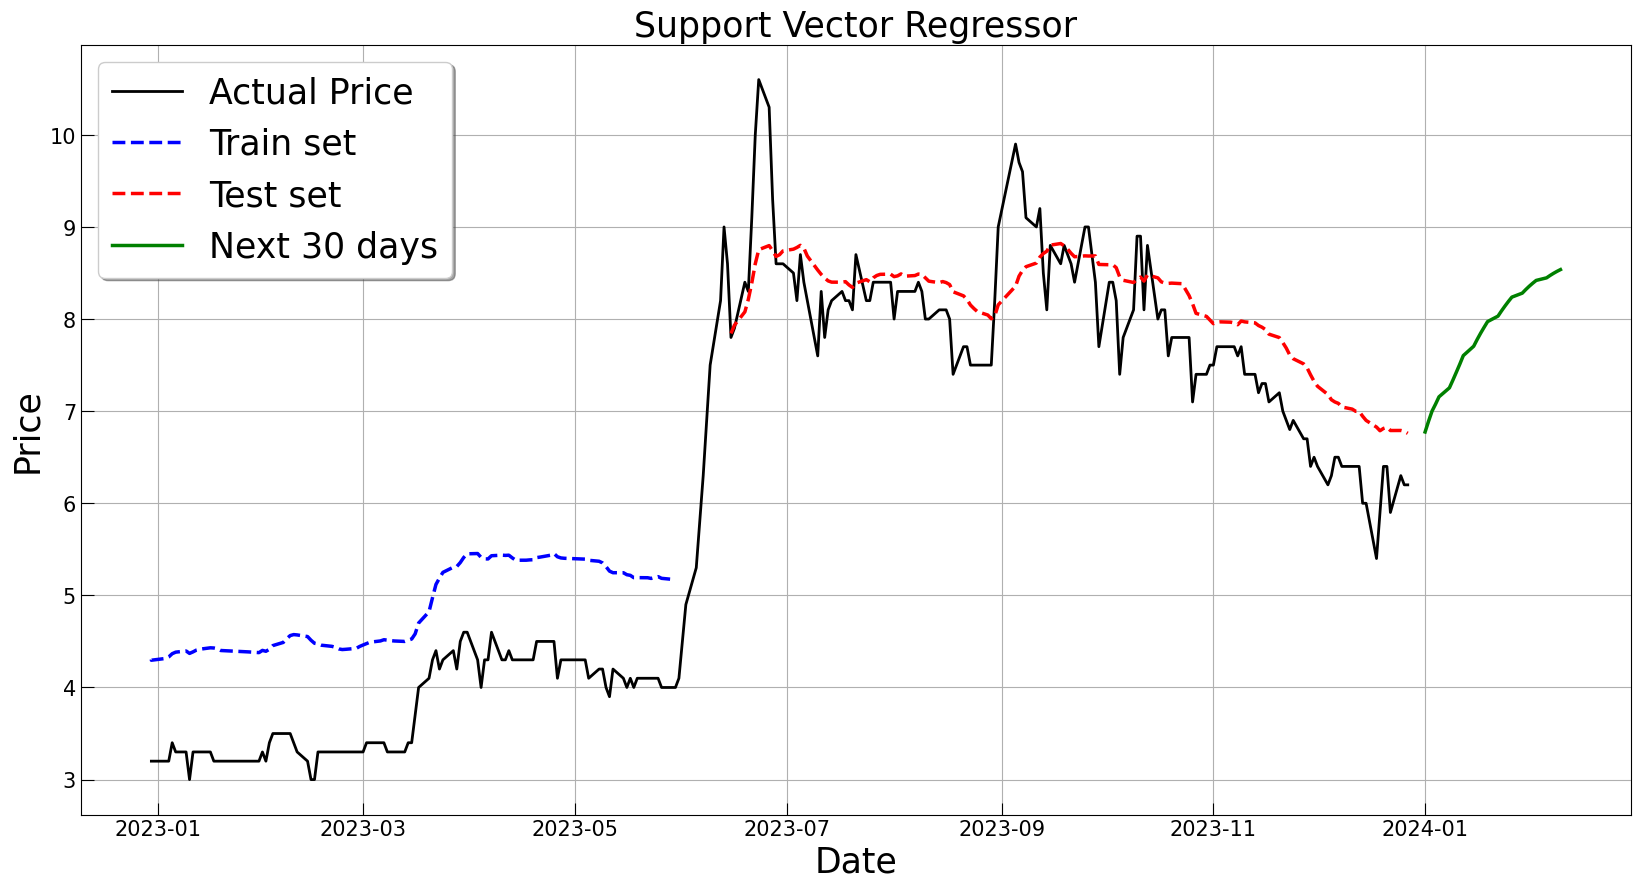

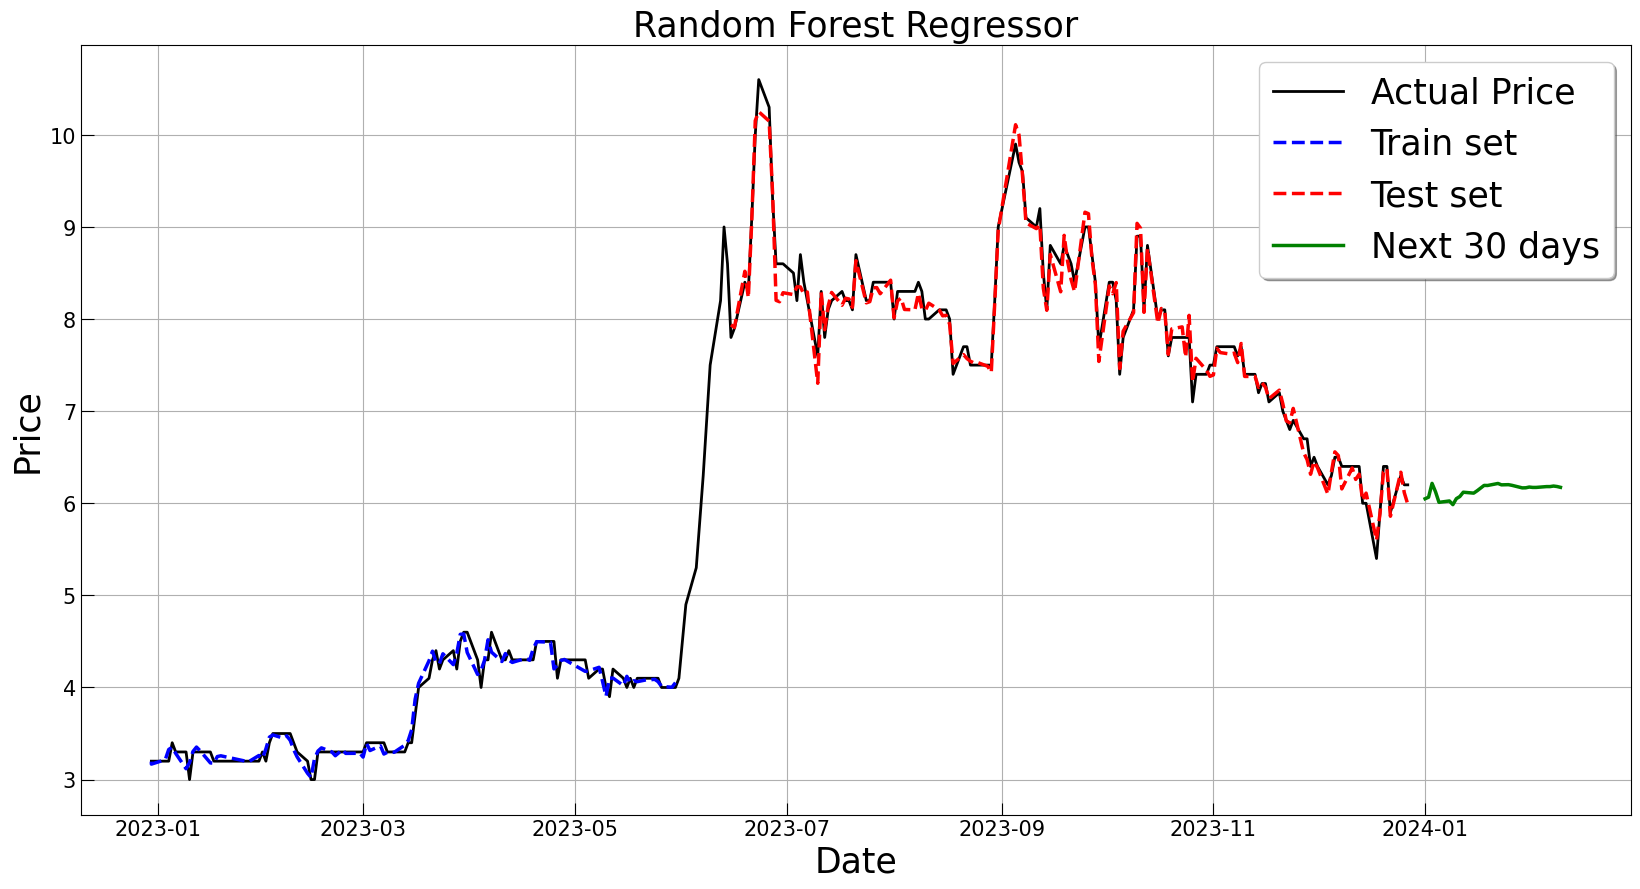

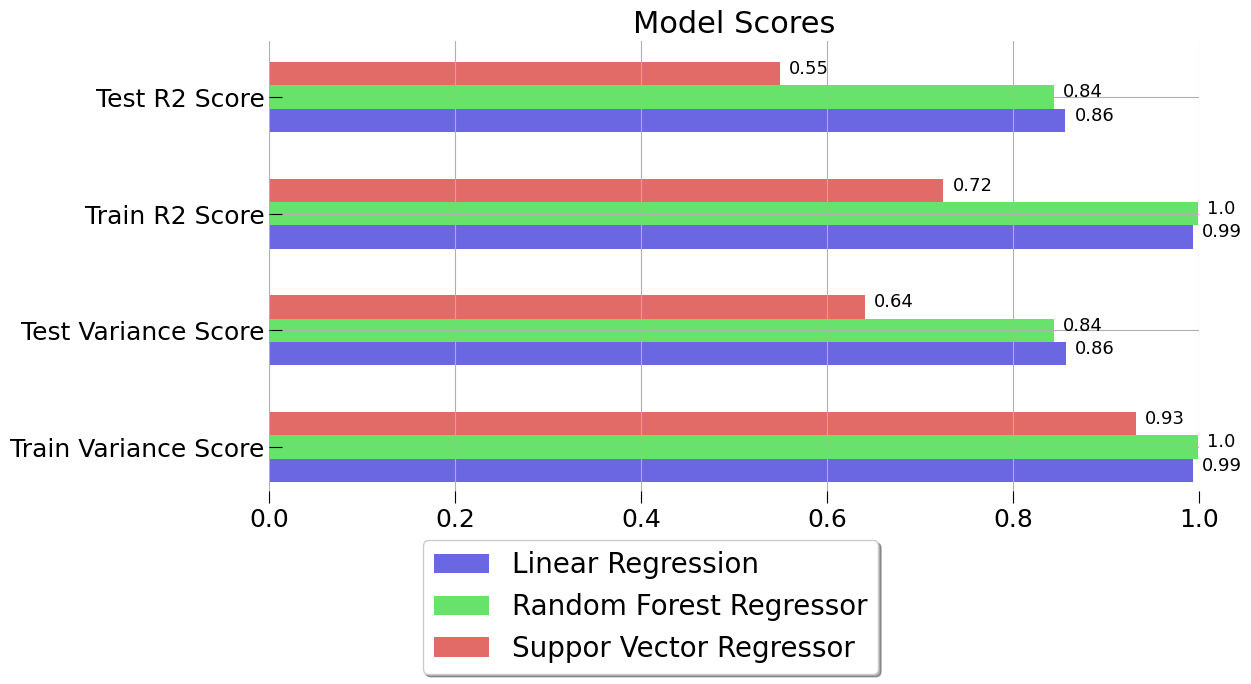

In [21]:
if __name__ == '__main__':
    df = pd.read_csv('/kaggle/input/newforecast/output.csv')

    # Chọn các điểm dữ liệu có cột 'code' bằng 'CET'
    df = df[df['code'] == 'CET']
    # Sắp xếp DataFrame theo cột ngày
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')

    # model_name = 'RandomForestRegressor'
    test_size = 0.05
    lookback = 10
    pred_ndays = 30

    train_var_list = []
    train_r2_list = []
    test_var_list = []
    test_r2_list = []

    for model_name in ['Linear Regression','Support Vector Regressor','Random Forest Regressor']:
        print("=======================")

        metric, train_df, test_df, pred_df = regression_model(model_name,df,test_size=test_size,\
            lookback=lookback,pred_ndays=pred_ndays).run()
        
        train_var_list.append(metric['train_variance_score'].iloc[0])
        train_r2_list.append(metric['train_r2_score'].iloc[0])

        test_var_list.append(metric['test_variance_score'].iloc[0])
        test_r2_list.append(metric['test_r2_score'].iloc[0])

        plot_result(train_df, test_df, pred_df)
        print(metric)
        print(model_name + " finished")
        
        if model_name == 'Random Forest Regressor':
            print('Gia tri du đoan cua random forest:', pred_df)
            pred_df.to_csv('Random Forest prediction.csv', index = False)

    plot_metric(train_var_list, train_r2_list, test_var_list, test_r2_list)
